In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

In [ ]:
DEVICE = 'cpu'

### Imports

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
import torchvision
import torchvision.transforms as transforms

In [7]:
from torchvision.transforms import InterpolationMode

In [8]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import BoundedParameter

In [9]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [10]:
from svetlanna.transforms import ToWavefront

In [11]:
# datasets of wavefronts
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import IlluminatedApertureDataset

In [12]:
from tqdm import tqdm

In [13]:
import json

In [14]:
from datetime import datetime

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Optical Neural Network

In that example notebook we will make some experiments^ based on a n opticel network architecture proposed in [the article](https://www.science.org/doi/10.1126/science.aat8084).

# 0. Experiment parameters

In [16]:
working_frequency = 0.4 * 1e12 # [Hz]
C_CONST = 299_792_458  # [m / s]

In [17]:
EXP_NUMBER = 1

In [18]:
EXP_CONDITIONS = {
    # SIMULATION PARAMS
    'wavelength'  : C_CONST / working_frequency,  # [m]
    'layer_size_m': 8 * 1e-2 / 2 * 3,  # [m] - x and y sizes are equal!
    'layer_nodes' : int(100 / 2 * 3),  # 100,
    # TOOLS
    'tensorboard' : False,  # to use tensorboard or not!
    # DATASET
    'digit_resize' : 17,  # the actual digit size after resize (in nodes)
    'ds_apertures': True,  # if dataset is created with diigit-shaped apertures (True) or with direct modulation (False)
        # must be specified if 'ds_apertures' == False, values: 'amp', 'phase' or 'both'
    'ds_modulation': None, 
        # must be specified if 'ds_apertures' == True
    'gauss_waist_radius': 2e-2,  # [m] - gaussian beam for dataset creation
    'distance_to_aperture': 3e-2,  # [m]
    # SETUP
    'propagator': 'AS',  # FreeSpase propagation method: 'AS' or 'fresnel' (also needed for dataset with apertures)
        # diffractive layers
    'n_diff_layers': 5,  # number of diffractive layers
    'diff_layer_max_phase': torch.pi,  # maximal phase for each DiffractiveLayer
    'diff_layer_mask_init': 'const',  # initialization of DiffractiveLayer masks: 'const' or 'random'
    'diff_layers_seeds': 123,  # if 'random': seed to generate seeds to init all masks!
        # free space
    'layers_distance': 3e-2,  # [m], distance between layers
        # apertures
    'add_apertures': True,  # if True - adds square apertures (in the middle) before each diffractive layer
    'apertures_size': (50, 50),  # size of additional apertures in a setup
        # detector
    'detector_zones': 'segments',  # form of a detector zones: 'squares' or 'circles' or 'strips'
    'detector_transpose': False,  # transpose detector or not (makes 'strips' horizontal instead of vertical)
    # TRAINING PROCESS
    'train_bs': 8,
    'val_bs': 20,  # batch sizes
    'train_split_seed': 178,  # seed for a data split on train/validation
    'epochs': 10,
}

In [19]:
# import SummaryWriter from tensorboard

if 'tensorboard' in EXP_CONDITIONS.keys():
    if EXP_CONDITIONS['tensorboard']:

        %pip install tensorboard
        from torch.utils.tensorboard import SummaryWriter


In [20]:
today_date = datetime.today().strftime('%d-%m-%Y')

RESULTS_FOLDER = (
    f'models/03_mnist_experiments/{today_date}_experiment_{EXP_NUMBER:02d}'
)

RESULTS_FOLDER

'models/03_mnist_experiments/13-12-2024_experiment_01'

In [21]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [22]:
# save experiment conditions
json.dump(EXP_CONDITIONS, open(f'{RESULTS_FOLDER}/conditions.json', 'w'))

In [23]:
# OR read conditions from file:
# EXP_CONDITIONS = json.load(open(f'{RESULTS_FOLDER}/conditions.json))
# print(EXP_CONDITIONS)

# 1. Simulation parameters

In [24]:
working_wavelength = EXP_CONDITIONS['wavelength']  # [m]
print(f'lambda = {working_wavelength * 1e6:.3f} um')

lambda = 749.481 um


In [25]:
# physical size of each layer (from the article) - (8 x 8) [cm]
x_layer_size_m = EXP_CONDITIONS['layer_size_m']  # [m]
y_layer_size_m = x_layer_size_m

In [26]:
# number of neurons in simulation
x_layer_nodes = EXP_CONDITIONS['layer_nodes']
y_layer_nodes = x_layer_nodes

In [27]:
print(f'Layer size (neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (neurons): 150 x 150 = 22500


In [28]:
neuron_size = x_layer_size_m / x_layer_nodes  # [m]  increase two times!
print(f'Neuron size = {neuron_size * 1e6:.3f} um')

Neuron size = 800.000 um


In [29]:
# simulation parameters for the rest of the notebook

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Dataset preparation (Data Engineer)

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [30]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = './data'  # folder to store data

### 2.1.1. Train/Test datasets of images

In [31]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=True,
)

In [32]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=True,
)

In [33]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Train/Test datasets of wavefronts

In [34]:
DS_WITH_APERTURES = EXP_CONDITIONS['ds_apertures'] 
# if True we use IlluminatedApertureDataset to create datasets of Wavefronts
# else - DatasetOfWavefronts
DS_WITH_APERTURES

True

In [35]:
# select modulation type for DatasetOfWavefronts if DS_WITH_APERTURES == False
MODULATION_TYPE = EXP_CONDITIONS['ds_modulation']  # 'phase', 'amp', 'amp&phase'

# select method and distance for a FreeSpace in IlluminatedApertureDataset
DS_METHOD = EXP_CONDITIONS['propagator']
DS_DISTANCE = EXP_CONDITIONS['distance_to_aperture']  # [m]

DS_BEAM = Wavefront.gaussian_beam(
    simulation_parameters=SIM_PARAMS,
    waist_radius=EXP_CONDITIONS['gauss_waist_radius'],  # [m]
)

In [36]:
# image resize to match SimulationParameters
resize_y = EXP_CONDITIONS['digit_resize']
resize_x = resize_y  # shape for transforms.Resize

pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [37]:
# compose all transforms for DatasetOfWavefronts
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]  
)

# compose all transforms for IlluminatedApertureDataset
image_to_aperture = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
  ]  
)

In [38]:
# TRAIN dataset of WAVEFRONTS
if not DS_WITH_APERTURES:
    mnist_wf_train_ds = DatasetOfWavefronts(
        init_ds=mnist_train_ds,  # dataset of images
        transformations=image_transform_for_ds,  # image transformation
        sim_params=SIM_PARAMS,  # simulation parameters
    )
else:
    mnist_wf_train_ds = IlluminatedApertureDataset(
        init_ds=mnist_train_ds,  # dataset of images
        transformations=image_to_aperture,  # image transformation
        sim_params=SIM_PARAMS,  # simulation parameters
        beam_field=DS_BEAM,
        distance=DS_DISTANCE,
        method=DS_METHOD,
    )

In [39]:
# TEST dataset of WAVEFRONTS
if not DS_WITH_APERTURES:
    mnist_wf_test_ds = DatasetOfWavefronts(
        init_ds=mnist_test_ds,  # dataset of images
        transformations=image_transform_for_ds,  # image transformation
        sim_params=SIM_PARAMS,  # simulation parameters
    )
else:
    mnist_wf_test_ds = IlluminatedApertureDataset(
        init_ds=mnist_test_ds,  # dataset of images
        transformations=image_to_aperture,  # image transformation
        sim_params=SIM_PARAMS,  # simulation parameters
        beam_field=DS_BEAM,
        distance=DS_DISTANCE,
        method=DS_METHOD,
    )

In [40]:
print(f'Train data: {len(mnist_wf_train_ds)}')
print(f'Test data : {len(mnist_wf_test_ds)}')

Train data: 60000
Test data : 10000


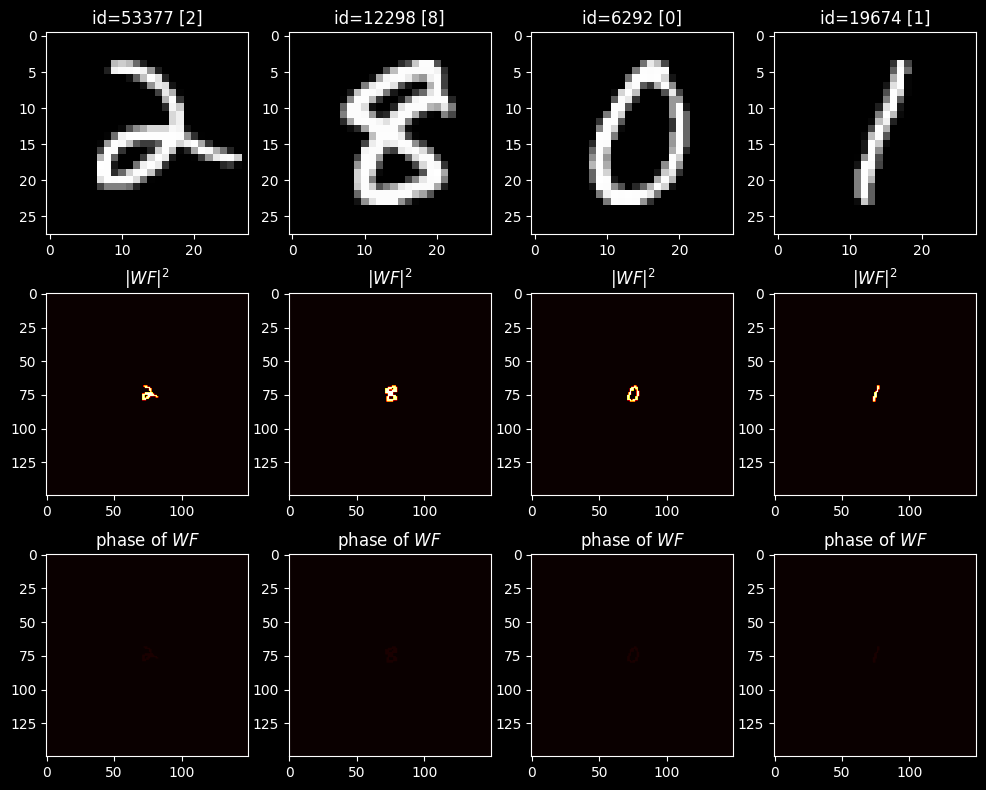

In [41]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []
cmap = 'hot'

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity[0], cmap=cmap,
        vmin=0, vmax=1
    )
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(
        wavefront.phase[0], cmap=cmap,
        vmin=0, vmax= 2 * torch.pi
    )

plt.show()

# 3. Optical network

In [42]:
NUM_OF_DIFF_LAYERS = EXP_CONDITIONS['n_diff_layers']  # number of diffractive layers
FREE_SPACE_DISTANCE = EXP_CONDITIONS['layers_distance']  # [m]

## 3.1. Architecture

### 3.1.1. List of Elements

> To help with the 3D-printing and fabrication of the $D^2NN$ design, a sigmoid function was used to limit the phase value of each neuron to $0-2π$ and $0-π$, for imaging and classifier networks, respectively.

In [43]:
MAX_PHASE = EXP_CONDITIONS['diff_layer_max_phase']

In [44]:
from src.for_setup import get_const_free_space, get_random_diffractive_layer
from torch.nn import functional

Function to construct a list of elements:

In [45]:
# WE WILL ADD APERTURES BEFORE EACH DIFFRACTIVE LAYER OF THE SIZE:
ADD_APERTURES = EXP_CONDITIONS['add_apertures']
APERTURE_SZ = EXP_CONDITIONS['apertures_size']

In [46]:
def get_elements_list(
    num_layers,
    simulation_parameters: SimulationParameters,
    freespace_method,
    masks_seeds,
    apertures=False,
    aperture_size=(100, 100)
):
    """
    Composes a list of elements for setup.
        Optical system: FS|DL|FS|...|FS|DL|FS|Detector
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_method : str
        Propagation method for free spaces in a setup.
    masks_seeds : torch.Tensor()
        Torch tensor of random seeds to generate masks for diffractive layers.

    Returns
    -------
    elements_list : list(Element)
        List of Elements for an optical setup.
    """
    elements_list = []  # list of elements

    if apertures:  # equal masks for all apertures (select a part in the middle)
        aperture_mask = torch.ones(size=aperture_size)

        y_nodes, x_nodes = simulation_parameters.axes_size(axs=('H', 'W'))
        y_mask, x_mask = aperture_mask.size()
        pad_top = int((y_nodes - y_mask) / 2)
        pad_bottom = y_nodes - pad_top - y_mask
        pad_left = int((x_nodes - x_mask) / 2)
        pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad
        
        # padding transform to match aperture size with simulation parameters     
        aperture_mask = functional.pad(
            input=aperture_mask,
            pad=(pad_left, pad_right, pad_top, pad_bottom),
            mode='constant',
            value=0
        )

    # compose architecture
    for ind_layer in range(num_layers):
        if ind_layer == 0:
            # first FreeSpace layer before first DiffractiveLayer
            elements_list.append(
                get_const_free_space(
                    simulation_parameters,  # simulation parameters for the notebook
                    FREE_SPACE_DISTANCE,  # in [m]
                    freespace_method=freespace_method,
                )
            )
    
        # add aperture before each diffractive layer
        if apertures:
            elements_list.append(
                elements.Aperture(
                    simulation_parameters=simulation_parameters,
                    mask=nn.Parameter(aperture_mask, requires_grad=False)
                )
            )
            
        # add DiffractiveLayer
        elements_list.append(
            get_random_diffractive_layer(
                simulation_parameters,  # simulation parameters for the notebook
                mask_seed=masks_seeds[ind_layer].item(),
                max_phase=MAX_PHASE
            )
        )
        # add FreeSpace
        elements_list.append(
            get_const_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                FREE_SPACE_DISTANCE,  # in [m]
                freespace_method=freespace_method,
            )
        )
    
    # add Detector in the end of the system!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # detector that returns intensity
        )
    )

    return elements_list

Constants for a setup initialization:

In [47]:
FREESPACE_METHOD = EXP_CONDITIONS['propagator'] # TODO: 'AS' returns nan's?

if EXP_CONDITIONS['diff_layer_mask_init'] == 'random':
    MASKS_SEEDS = torch.randint(
        low=0, high=100,
        size=(NUM_OF_DIFF_LAYERS,),
        generator=torch.Generator().manual_seed(EXP_CONDITIONS['diff_layers_seeds'])
        # to generate the same set of initial masks
    )  # for the same random generation

if EXP_CONDITIONS['diff_layer_mask_init'] == 'const':
    MASKS_SEEDS = torch.ones(size=(NUM_OF_DIFF_LAYERS,)) * torch.pi / 2  # constant masks init

MASKS_SEEDS

tensor([1.5708, 1.5708, 1.5708, 1.5708, 1.5708])

### 3.1.2. Compose `LinearOpticalSetup`

In [48]:
def get_setup(
    simulation_parameters, 
    num_layers, 
    apertures=False, 
    aperture_size=(100,100)
):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers,
        simulation_parameters,
        FREESPACE_METHOD,
        MASKS_SEEDS,
        apertures=apertures,
        aperture_size=aperture_size
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [49]:
lin_optical_setup = get_setup(
    SIM_PARAMS,
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES, 
    aperture_size=APERTURE_SZ
)
# Comment: Lin - a surname of the first author of the article

In [50]:
lin_optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): Aperture()
  (2): DiffractiveLayer()
  (3): FreeSpace()
  (4): Aperture()
  (5): DiffractiveLayer()
  (6): FreeSpace()
  (7): Aperture()
  (8): DiffractiveLayer()
  (9): FreeSpace()
  (10): Aperture()
  (11): DiffractiveLayer()
  (12): FreeSpace()
  (13): Aperture()
  (14): DiffractiveLayer()
  (15): FreeSpace()
  (16): Detector()
)

#### Example of a wavefrnt propagation

In [51]:
example_wf = mnist_wf_train_ds[128][0]

In [52]:
mnist_wf_train_ds[128][1]

1

In [53]:
setup_scheme, wavefronts = lin_optical_setup.stepwise_forward(example_wf)

-(0)-> [1. FreeSpace] -(1)-> [2. Aperture] -(2)-> [3. DiffractiveLayer] -(3)-> [4. FreeSpace] -(4)-> [5. Aperture] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. Aperture] -(8)-> [9. DiffractiveLayer] -(9)-> [10. FreeSpace] -(10)-> [11. Aperture] -(11)-> [12. DiffractiveLayer] -(12)-> [13. FreeSpace] -(13)-> [14. Aperture] -(14)-> [15. DiffractiveLayer] -(15)-> [16. FreeSpace] -(16)-> [17. Detector] -(17)->


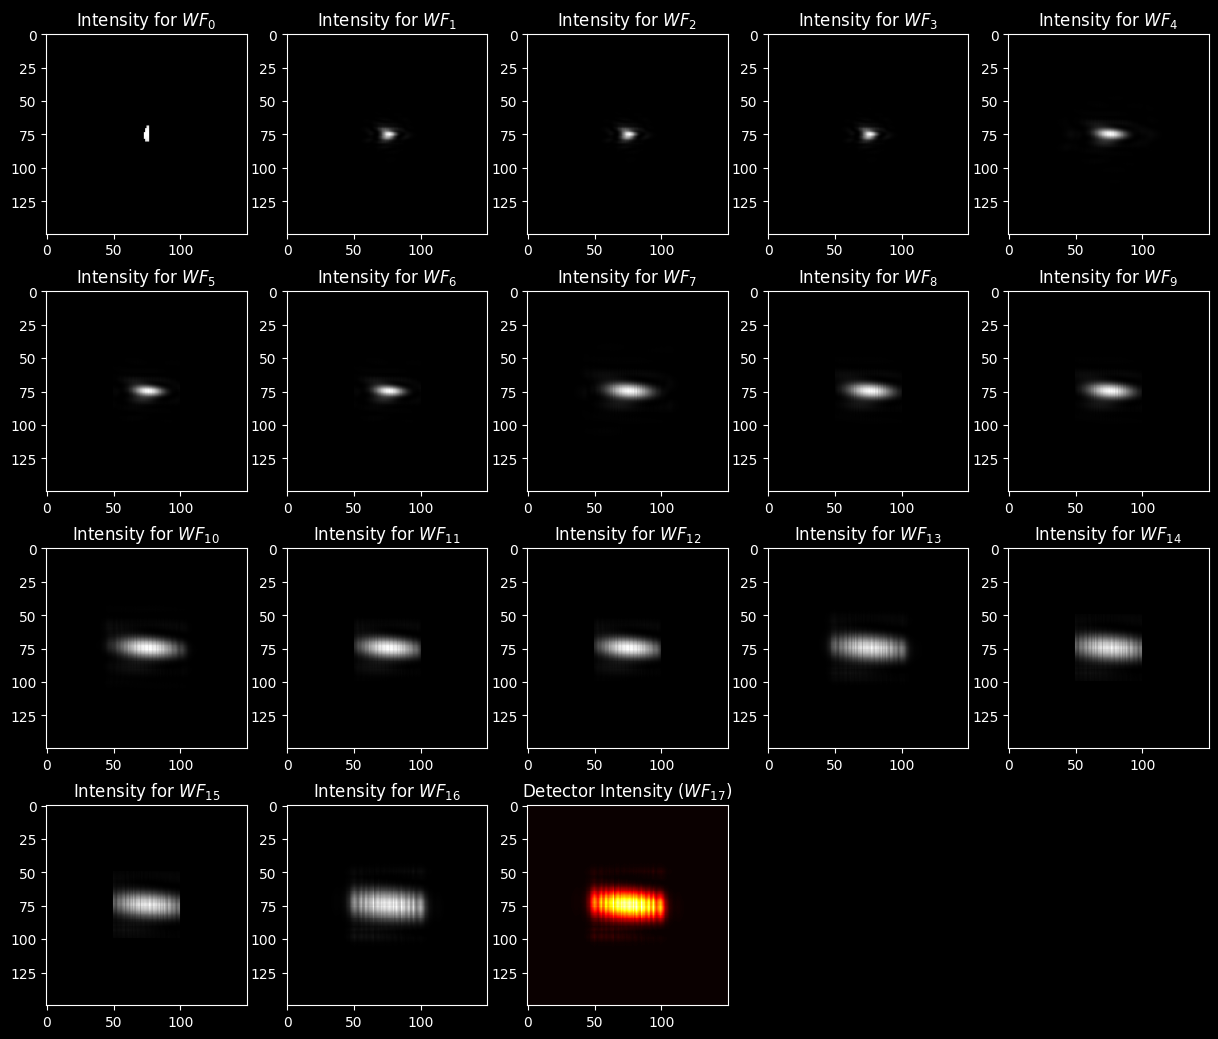

In [54]:
print(setup_scheme)  # prints propagation scheme

n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (len(lin_optical_setup.net) // n_cols) + 1

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # Detector has no phase!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront[0].intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # Detector output (not a wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront[0].detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
            
    # Comment: Detector output is Tensor! It has no methods of Wavefront (like .phase or .intensity)!

plt.show()

### 3.1.3 Detector processor

In [55]:
number_of_classes = 10

In [56]:
import src.detector_segmentation as detector_segmentation
# Functions to segment detector: squares_mnist, circles, angular_segments

In [57]:
if ADD_APERTURES or APERTURE_SZ:
    y_detector_nodes, x_detector_nodes = APERTURE_SZ
else:
    y_detector_nodes, x_detector_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))

In [58]:
ADD_APERTURES

True

#### Detector mask (square zones)

In [59]:
detector_squares_mask = detector_segmentation.squares_mnist(
    y_detector_nodes, x_detector_nodes,  # size of a detector or an aperture (in the middle of detector)
    SIM_PARAMS
)

#### Detector mask (circular zones)

In [60]:
detector_circles_mask = detector_segmentation.circles(
    y_detector_nodes, x_detector_nodes,  # size of a detector or an aperture (in the middle of detector)
    number_of_classes,
    SIM_PARAMS
)

#### Detector mask (angular segments zones)

In [61]:
detector_angles_mask = detector_segmentation.angular_segments(
    y_detector_nodes, x_detector_nodes,  # size of a detector or an aperture (in the middle of detector)
    number_of_classes,
    SIM_PARAMS
)

#### Detector processor

In [62]:
CIRCLES_ZONES = EXP_CONDITIONS['detector_zones'] == 'circles'
CIRCLES_ZONES

False

In [63]:
if EXP_CONDITIONS['detector_zones'] == 'circles':
    selected_mask = detector_circles_mask
    print('circles selected!')

if EXP_CONDITIONS['detector_zones'] == 'squares':
    selected_mask = detector_squares_mask
    print('squares selected!')

if EXP_CONDITIONS['detector_zones'] == 'segments':
    selected_mask = detector_angles_mask
    print('angular segments selected!')

if EXP_CONDITIONS['detector_zones'] == 'strips':
    selected_mask = None
    print('strips selected!')

angular segments selected!


In [64]:
detector_processor = DetectorProcessorClf(
    num_classes=number_of_classes,
    simulation_parameters=SIM_PARAMS,
    segmented_detector=selected_mask,  # choose a mask!
    segments_zone_size=APERTURE_SZ
)

In [65]:
if 'detector_transpose' in EXP_CONDITIONS.keys():
    if EXP_CONDITIONS['detector_transpose']:
        detector_processor.segmented_detector = detector_processor.segmented_detector.T

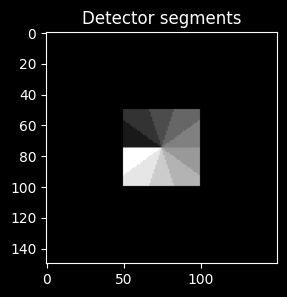

In [66]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(detector_processor.segmented_detector, cmap='grey')

plt.show()

#### Zones visualization. To draw zones on a detector...

In [67]:
ZONES_HIGHLIGHT_COLOR = 'w'
ZONES_LW = 0.5
selected_detector_mask = detector_processor.segmented_detector.clone().detach()

In [68]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []
    
    if EXP_CONDITIONS['detector_zones'] == 'circles':
        for ind_class in range(number_of_classes):
            # use `circles_radiuses`, `x_layer_size_m`, `x_layer_nodes`
            rad_this = (circles_radiuses[ind_class] / x_layer_size_m * x_layer_nodes)
                    
            zone_circ = patches.Circle(
                (x_layer_nodes / 2, y_layer_nodes / 2), 
                rad_this, 
                linewidth=ZONES_LW, 
                edgecolor=ZONES_HIGHLIGHT_COLOR,
                facecolor='none'
            )
            
            zones_patches.append(zone_circ)
    else:
        if EXP_CONDITIONS['detector_zones'] == 'segments':
            class_segment_angle = 2 * torch.pi / number_of_classes
            len_lines_nodes = int(x_layer_nodes / 2)

            delta = 0.5
            idx_y, idx_x = (detector_mask > -1).nonzero(as_tuple=True)
            zone_rect = patches.Rectangle(
                (idx_x[0] - delta, idx_y[0] - delta), 
                idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
                linewidth=ZONES_LW, 
                edgecolor=ZONES_HIGHLIGHT_COLOR,
                facecolor='none'
            )
            zones_patches.append(zone_rect)
            
            ang = torch.pi
            x_center, y_center = int(x_layer_nodes / 2), int(y_layer_nodes / 2)
            for ind_class in range(number_of_classes):
                path_line = Path(
                    [
                        (x_center, y_center), 
                        (
                            x_center + len_lines_nodes * np.cos(ang), 
                            y_center + len_lines_nodes * np.sin(ang)
                        ),
                    ],
                    [
                        Path.MOVETO,
                        Path.LINETO
                    ]
                )
                bound_line = patches.PathPatch(
                    path_line, 
                    facecolor='none', 
                    lw=ZONES_LW,
                    edgecolor=ZONES_HIGHLIGHT_COLOR,
                )

                zones_patches.append(bound_line)
                
                ang += class_segment_angle
        else:
            delta = 0.5
            
            for ind_class in range(number_of_classes):
                idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
                
                zone_rect = patches.Rectangle(
                    (idx_x[0] - delta, idx_y[0] - delta), 
                    idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
                    linewidth=ZONES_LW, 
                    edgecolor=ZONES_HIGHLIGHT_COLOR,
                    facecolor='none'
                )
                
                zones_patches.append(zone_rect)

    return zones_patches

# 4. Training of the network

Variables at the moment
- `lin_optical_setup` : `LinearOpticalSetup` – a linear optical network composed of Elements
- `detector_processor` : `DetectorProcessorClf` – this layer process an image from the detector and calculates probabilities of belonging to classes.

In [69]:
DEVICE

device(type='cpu')

## 4.1. Prepare some stuff for training

### 4.1.1. `DataLoader`'s

In [70]:
train_bs = EXP_CONDITIONS['train_bs']  # a batch size for training set
val_bs = EXP_CONDITIONS['val_bs']

> Forthis task, phase-only transmission masks weredesigned by training a five-layer $D^2 NN$ with $55000$ images ($5000$ validation images) from theMNIST (Modified National Institute of Stan-dards and Technology) handwritten digit data-base.

In [71]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(EXP_CONDITIONS['train_split_seed'])  # for reproducibility
)

In [72]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

Info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> We used the stochastic gradient descent algorithm, Adam, to back-propagate the errors and update the
layers of the network to minimize the loss function.

In [73]:
optimizer_clf = torch.optim.Adam(
    params=lin_optical_setup.net.parameters()  # NETWORK PARAMETERS!
)

In [74]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

### 4.1.3. Training and evaluation loops

In [75]:
from src.clf_loops import onn_train_clf, onn_validate_clf

## 4.2. Training of the optical network

### 4.2.1. Before training

#### Diffractive layers masks

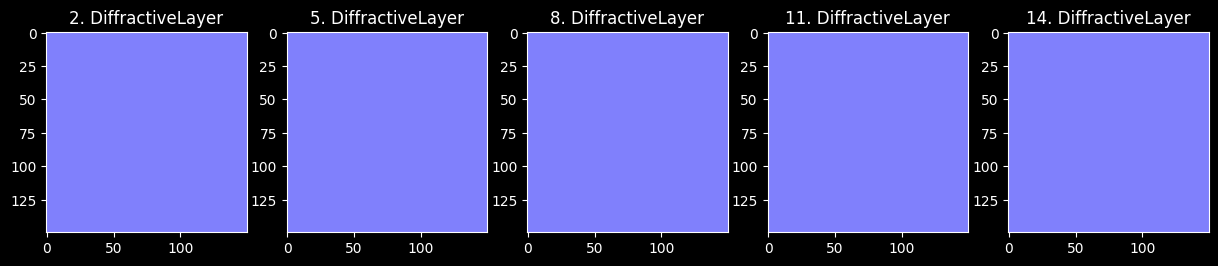

In [91]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

lin_architecture_elements_list = get_elements_list(
    NUM_OF_DIFF_LAYERS,
    SIM_PARAMS,
    FREESPACE_METHOD,
    MASKS_SEEDS,
    apertures=ADD_APERTURES,
    aperture_size=APERTURE_SZ
)

cmap = 'gist_stern'

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

for ind_layer, layer in enumerate(lin_architecture_elements_list):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_layer}. DiffractiveLayer')

        im = ax_this.imshow(
            layer.mask.detach().numpy(), cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        
        ind_diff_layer += 1

plt.show()

#### Metrics for test dataset

In [77]:
lin_optical_setup = get_setup(
    SIM_PARAMS.to(DEVICE),
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES, 
    aperture_size=APERTURE_SZ
)

In [78]:
lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)

SIM_PARAMS = SIM_PARAMS.to(DEVICE)  # IMPORTANT!
detector_processor = detector_processor.to(DEVICE)

In [79]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

In [80]:
test_losses_0, _, test_accuracy_0 = onn_validate_clf(
    lin_optical_setup.net,  # optical network composed in 3.
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results before training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.14it/s]

Results before training on TEST set:
	CE loss : 2.304648
	Accuracy : 9.7 %


### 4.2.2. Training

In [111]:
n_epochs = EXP_CONDITIONS['epochs']
print_each = 1  # print each n'th epoch info

In [112]:
scheduler = None  # sheduler for a lr tuning during training 

In [113]:
# Recreate a system to restart training!

lin_optical_setup = get_setup(
    SIM_PARAMS.to(DEVICE),
    NUM_OF_DIFF_LAYERS,
    apertures=ADD_APERTURES, 
    aperture_size=APERTURE_SZ
)

# Linc optimizer to a recreated net!
optimizer_clf = torch.optim.Adam(
    params=lin_optical_setup.net.parameters()  # NETWORK PARAMETERS!
)

In [114]:
lin_optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): Aperture()
  (2): DiffractiveLayer()
  (3): FreeSpace()
  (4): Aperture()
  (5): DiffractiveLayer()
  (6): FreeSpace()
  (7): Aperture()
  (8): DiffractiveLayer()
  (9): FreeSpace()
  (10): Aperture()
  (11): DiffractiveLayer()
  (12): FreeSpace()
  (13): Aperture()
  (14): DiffractiveLayer()
  (15): FreeSpace()
  (16): Detector()
)

In [115]:
lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)

SIM_PARAMS = SIM_PARAMS.to(DEVICE)  # IMPORTANT!
detector_processor = detector_processor.to(DEVICE)  # detector processor also must be on device!

In [116]:
# tensorboard writer
if EXP_CONDITIONS['tensorboard']:
    # TODO: A custom name for a run?
    tensorboard_writer = SummaryWriter()
    print('Tensorboard writer created!')

Tensorboard writer created!


In [117]:
train_epochs_losses = []
val_epochs_losses = []  # to store losses of each epoch

train_epochs_acc = []
val_epochs_acc = []  # to store accuracies

torch.manual_seed(98)  # for reproducability?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = onn_train_clf(
        lin_optical_setup.net,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        detector_processor,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = onn_validate_clf(
        lin_optical_setup.net,  # optical network composed in 3.
        val_wf_loader,  # dataloader of validation set
        detector_processor,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')
            
    if scheduler:
        scheduler.step(mean_val_loss)

    # ---------------------------------------------------- TENSORBOARD SECTION
    if EXP_CONDITIONS['tensorboard']:
        #exprimentation tracking section: tensorboard
        tensorboard_writer.add_scalars(
            main_tag="Loss",
            tag_scalar_dict={
                "train_loss": mean_train_loss,
                "val_loss": mean_val_loss,
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
            },
            global_step=epoch
        )
    
        # image of SLM at each epoch
        diff_layer_number = 1
        for layer in lin_optical_setup.net:
            # save masks for Diffractive layers after each epoch
            if isinstance(layer, elements.DiffractiveLayer):
                mask_np = layer.mask.detach().unsqueeze(0).numpy()

                # TODO: Figure to add?
                # fig_this, ax_this =  plt.subplots(1, 1, figsize=(5, 4))
                # im_this = ax_this.imshow(
                #     layer.mask.detach().numpy(), cmap=cmap,
                #     vmin=0, vmax=MAX_PHASE
                # )
                # cbar_this = fig.colorbar(im_this)
                # im_this.set_clim(0, MAX_PHASE)
                
                # WRITE
                tensorboard_writer.add_image(
                    f'DiffractiveLayer_{diff_layer_number}',
                    mask_np,
                    global_step=epoch
                )
                diff_layer_number += 1
        print(f'\t-> tensorboarded')
    # ---------------------------------------------------- TENSORBOARD SECTION
    
    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:09<00:00, 22.18it/s]


Training results
	CE loss : 2.026149
	Accuracy : 69.7 %
	------------   309.92 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:16<00:00, 15.28it/s]


Validation results
	CE loss : 1.976295
	Accuracy : 76.0 %
	------------   16.36 s
	-> tensorboarded
Epoch #2: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:25<00:00, 21.11it/s]


Training results
	CE loss : 1.954368
	Accuracy : 78.8 %
	------------   325.61 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:17<00:00, 14.38it/s]


Validation results
	CE loss : 1.944904
	Accuracy : 78.9 %
	------------   17.38 s
	-> tensorboarded
Epoch #3: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [05:15<00:00, 21.78it/s]


Training results
	CE loss : 1.932177
	Accuracy : 80.4 %
	------------   315.66 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:18<00:00, 13.83it/s]


Validation results
	CE loss : 1.927474
	Accuracy : 80.7 %
	------------   18.08 s
	-> tensorboarded
Epoch #4: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:05<00:00, 18.79it/s]


Training results
	CE loss : 1.919771
	Accuracy : 81.1 %
	------------   365.97 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.67it/s]


Validation results
	CE loss : 1.918410
	Accuracy : 81.6 %
	------------   19.74 s
	-> tensorboarded
Epoch #5: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:09<00:00, 18.63it/s]


Training results
	CE loss : 1.911985
	Accuracy : 81.5 %
	------------   369.08 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:21<00:00, 11.77it/s]


Validation results
	CE loss : 1.911945
	Accuracy : 81.1 %
	------------   21.25 s
	-> tensorboarded
Epoch #6: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:21<00:00, 18.02it/s]


Training results
	CE loss : 1.906370
	Accuracy : 81.9 %
	------------   381.45 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.72it/s]


Validation results
	CE loss : 1.906746
	Accuracy : 82.1 %
	------------   19.66 s
	-> tensorboarded
Epoch #7: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:52<00:00, 16.68it/s]


Training results
	CE loss : 1.902148
	Accuracy : 82.1 %
	------------   412.09 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:20<00:00, 12.10it/s]


Validation results
	CE loss : 1.901731
	Accuracy : 81.5 %
	------------   20.67 s
	-> tensorboarded
Epoch #8: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:38<00:00, 17.25it/s]


Training results
	CE loss : 1.899022
	Accuracy : 82.0 %
	------------   398.52 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Validation results
	CE loss : 1.900397
	Accuracy : 80.5 %
	------------   19.51 s
	-> tensorboarded
Epoch #9: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [07:19<00:00, 15.64it/s]


Training results
	CE loss : 1.896814
	Accuracy : 82.2 %
	------------   439.46 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:20<00:00, 12.49it/s]


Validation results
	CE loss : 1.898544
	Accuracy : 82.6 %
	------------   20.02 s
	-> tensorboarded
Epoch #10: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [06:51<00:00, 16.70it/s]


Training results
	CE loss : 1.894883
	Accuracy : 82.3 %
	------------   411.80 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [00:17<00:00, 14.02it/s]

Validation results
	CE loss : 1.896155
	Accuracy : 81.4 %
	------------   17.83 s
	-> tensorboarded


In [120]:
if EXP_CONDITIONS['tensorboard']:
    tensorboard_writer.flush()
    tensorboard_writer.close()

In [ ]:
# run tensorboard
# !tensorboard --logdir=runs

### Learning curves

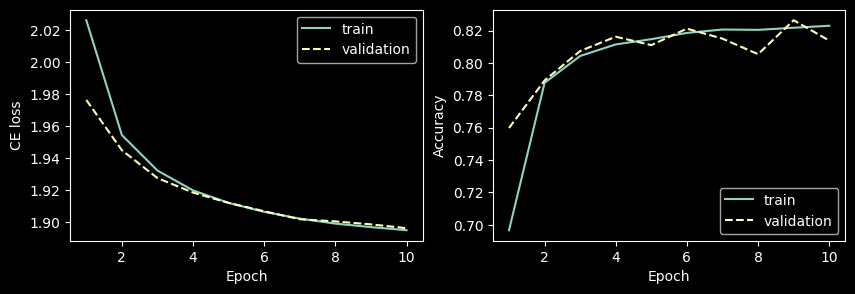

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), train_epochs_losses, label='train')
axs[0].plot(range(1, n_epochs + 1), val_epochs_losses, linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

In [122]:
# array with all losses
# TODO: make with PANDAS?
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

### Saving

In [123]:
RESULTS_FOLDER

'models/03_mnist_experiments/13-12-2024_experiment_01'

In [124]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [125]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/optical_setup_net.pth'
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

In [126]:
# saving model
torch.save(lin_optical_setup.net.state_dict(), model_filepath)

In [127]:
# saving losses
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)

### 4.2.3. Trained masks

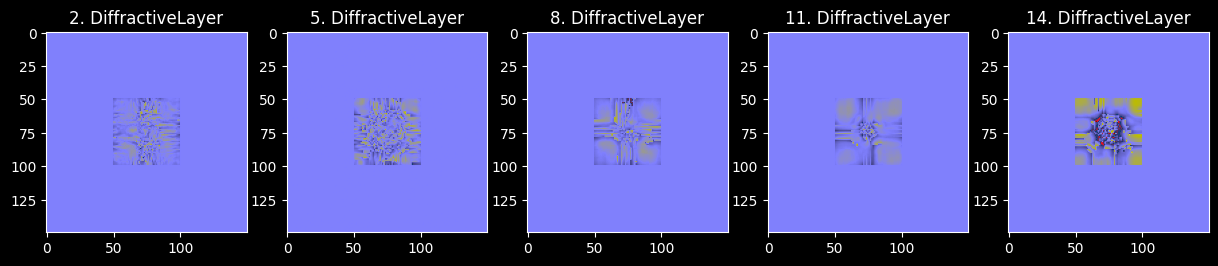

In [128]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'

for ind_layer, layer in enumerate(lin_optical_setup.net):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_layer}. DiffractiveLayer')

        trained_mask = layer.mask.detach()

        # mask_seed = MASKS_SEEDS[ind_diff_layer].item()
        # random_mask = torch.rand(
        #     size=(sim_params.y_nodes, sim_params.x_nodes),
        #     generator=torch.Generator().manual_seed(mask_seed)
        # ) * (MAX_PHASE)
        
        ax_this.imshow(         
            trained_mask, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

plt.show()